In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate

import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50


Image_Size = [384, 1216]
Gradient_Clipping = 0.8


Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'ensemble_voting'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = True
checkpoint_dir = '../trained' + '_' + Model_Name
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)
dir_checkpoint = Path(checkpoint_dir)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 767.15it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    segnet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    enet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [unet_optimizer, segnet_optimizer, enet_optimizer]
    
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(unet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(segnet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(enet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    
    
    
else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [optimizer]
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    
    
    
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss

def grad_forback(models, losses, optim):
    optim.zero_grad(set_to_none=True)
    grad_scaler.scale(losses).backward()
    torch.nn.utils.clip_grad_norm_(models.parameters(), Gradient_Clipping)
    grad_scaler.step(optim)
    grad_scaler.update()    

def forward_and_backward(model, images, true_masks, amp, optimizers, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        
        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels

        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
            
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
            
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)
    
    
    if model_name == 'ensemble_voting':
        for _loss, _optiz in zip([unet_loss, segnet_loss, enet_loss], optimizers):
            grad_forback(model, _loss, _optiz)

        return model, unet_loss, segnet_loss, enet_loss
    else:
        for _loss, _optiz in zip([loss], optimizers):
            grad_forback(model, _loss, _optiz)
            
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optims, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                #voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score.cpu().detach().numpy())
                TrainLoss_list1.append(unet_loss.cpu().detach().numpy())
                valScore_list2.append(segnet_val_score.cpu().detach().numpy())
                TrainLoss_list2.append(segnet_loss.cpu().detach().numpy())                
                valScore_list3.append(enet_val_score.cpu().detach().numpy())
                TrainLoss_list3.append(enet_loss.cpu().detach().numpy())
                valScore_list4.append(voting_val_score.cpu().detach().numpy())
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                print('---')
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:17<00:00, 14.97img/s]

***
Unet Loss: 0.6588600873947144     Segnet Loss: 0.9160606861114502     Enet Loss: 1.0641694068908691
Voting Loss: 0.8796967267990112


Epoch 1/50:  99%|█████████▊| 200/203 [00:21<00:00,  9.50img/s]

---
Unet Validation Dice Score: 0.28675708174705505     Segnet Validation Dice Score: 0.11674978584051132     Enet Validation Dice Score: 0.2264721393585205
---
Ensemble Voting Validation Dice Loss: 1.3578845659891765
Ensemble Voting Validation Pixel Accuracy: 0.3414127282929002 
Ensemble Voting Validation MIoU: 0.20518112552949624
Ensemble Voting Validation Dice Score: 0.33861175179481506 



Epoch 2/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.24img/s]

***
Unet Loss: 0.6062265038490295     Segnet Loss: 0.5419138669967651     Enet Loss: 0.9683511853218079
Voting Loss: 0.7054971853892008


Epoch 2/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.61img/s]

---
Unet Validation Dice Score: 0.7368054986000061     Segnet Validation Dice Score: 0.11416870355606079     Enet Validation Dice Score: 0.2957947850227356
---
Ensemble Voting Validation Dice Loss: 0.8536696434020996
Ensemble Voting Validation Pixel Accuracy: 0.896192048725329 
Ensemble Voting Validation MIoU: 0.7227692998922512
Ensemble Voting Validation Dice Score: 0.7749819159507751 



Epoch 3/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.13img/s]

***
Unet Loss: 0.426252156496048     Segnet Loss: 0.35179251432418823     Enet Loss: 0.908413290977478
Voting Loss: 0.5621526539325714


Epoch 3/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.36img/s]

---
Unet Validation Dice Score: 0.7945287823677063     Segnet Validation Dice Score: 0.7626985907554626     Enet Validation Dice Score: 0.35035955905914307
---
Ensemble Voting Validation Dice Loss: 0.6460440158843994
Ensemble Voting Validation Pixel Accuracy: 0.9298358047217653 
Ensemble Voting Validation MIoU: 0.7911451547835472
Ensemble Voting Validation Dice Score: 0.8009864091873169 



Epoch 4/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.14img/s]

***
Unet Loss: 0.375144898891449     Segnet Loss: 0.30110469460487366     Enet Loss: 0.8166958093643188
Voting Loss: 0.4976484676202138


Epoch 4/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.48img/s]

---
Unet Validation Dice Score: 0.8501777648925781     Segnet Validation Dice Score: 0.8172677159309387     Enet Validation Dice Score: 0.4038708209991455
---
Ensemble Voting Validation Dice Loss: 0.5338476498921713
Ensemble Voting Validation Pixel Accuracy: 0.9391781990988213 
Ensemble Voting Validation MIoU: 0.8057847485469865
Ensemble Voting Validation Dice Score: 0.8499534726142883 



Epoch 5/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.16img/s]

***
Unet Loss: 0.3851325511932373     Segnet Loss: 0.2403312772512436     Enet Loss: 0.7708609104156494
Voting Loss: 0.46544157962004346


Epoch 5/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.40img/s]

---
Unet Validation Dice Score: 0.8290063738822937     Segnet Validation Dice Score: 0.8363245129585266     Enet Validation Dice Score: 0.45507678389549255
---
Ensemble Voting Validation Dice Loss: 0.5198531150817871
Ensemble Voting Validation Pixel Accuracy: 0.937646698533443 
Ensemble Voting Validation MIoU: 0.8071686276369903
Ensemble Voting Validation Dice Score: 0.8437914252281189 



Epoch 6/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.08img/s]

***
Unet Loss: 0.2968538999557495     Segnet Loss: 0.2614734172821045     Enet Loss: 0.69962078332901
Voting Loss: 0.419316033522288


Epoch 6/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.50img/s]

---
Unet Validation Dice Score: 0.8842856287956238     Segnet Validation Dice Score: 0.8303536772727966     Enet Validation Dice Score: 0.5128235220909119
---
Ensemble Voting Validation Dice Loss: 0.42797215779622394
Ensemble Voting Validation Pixel Accuracy: 0.9575206020422149 
Ensemble Voting Validation MIoU: 0.8529082035509626
Ensemble Voting Validation Dice Score: 0.8642125129699707 



Epoch 7/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.98img/s]

***
Unet Loss: 0.3462904989719391     Segnet Loss: 0.230447918176651     Enet Loss: 0.6656520366668701
Voting Loss: 0.41413015127182007


Epoch 7/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.49img/s]

---
Unet Validation Dice Score: 0.8530364036560059     Segnet Validation Dice Score: 0.8495500683784485     Enet Validation Dice Score: 0.5615329146385193
---
Ensemble Voting Validation Dice Loss: 0.4450579484303792
Ensemble Voting Validation Pixel Accuracy: 0.9399751362047697 
Ensemble Voting Validation MIoU: 0.8163541757158108
Ensemble Voting Validation Dice Score: 0.8577868342399597 



Epoch 8/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
Unet Loss: 0.25540149211883545     Segnet Loss: 0.14294713735580444     Enet Loss: 0.5877388715744019
Voting Loss: 0.3286958336830139


Epoch 8/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.57img/s]

---
Unet Validation Dice Score: 0.8700599074363708     Segnet Validation Dice Score: 0.8329625129699707     Enet Validation Dice Score: 0.612339437007904
---
Ensemble Voting Validation Dice Loss: 0.39230934778849286
Ensemble Voting Validation Pixel Accuracy: 0.9490016468784266 
Ensemble Voting Validation MIoU: 0.8340804559114141
Ensemble Voting Validation Dice Score: 0.8588423728942871 



Epoch 9/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.91img/s]

***
Unet Loss: 0.26284676790237427     Segnet Loss: 0.13052010536193848     Enet Loss: 0.5353559255599976
Voting Loss: 0.3095742662747701


Epoch 9/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.51img/s]

---
Unet Validation Dice Score: 0.8728832602500916     Segnet Validation Dice Score: 0.8745154738426208     Enet Validation Dice Score: 0.6784058213233948
---
Ensemble Voting Validation Dice Loss: 0.3830400307973226
Ensemble Voting Validation Pixel Accuracy: 0.9499040570175439 
Ensemble Voting Validation MIoU: 0.8377775089557
Ensemble Voting Validation Dice Score: 0.8861878514289856 



Epoch 10/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.03img/s]

***
Unet Loss: 0.26114943623542786     Segnet Loss: 0.1329880803823471     Enet Loss: 0.5192595720291138
Voting Loss: 0.3044656962156296


Epoch 10/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.41img/s]

---
Unet Validation Dice Score: 0.890396237373352     Segnet Validation Dice Score: 0.8837621808052063     Enet Validation Dice Score: 0.7257027626037598
---
Ensemble Voting Validation Dice Loss: 0.35838985443115234
Ensemble Voting Validation Pixel Accuracy: 0.9494869834498355 
Ensemble Voting Validation MIoU: 0.8370225128773168
Ensemble Voting Validation Dice Score: 0.88990318775177 



Epoch 11/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.12img/s]

***
Unet Loss: 0.23537907004356384     Segnet Loss: 0.1602191925048828     Enet Loss: 0.5254948139190674
Voting Loss: 0.3070310254891713


Epoch 11/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.41img/s]

---
Unet Validation Dice Score: 0.9003517031669617     Segnet Validation Dice Score: 0.8786075711250305     Enet Validation Dice Score: 0.7605748176574707
---
Ensemble Voting Validation Dice Loss: 0.33509775002797443
Ensemble Voting Validation Pixel Accuracy: 0.9535784805030153 
Ensemble Voting Validation MIoU: 0.849026681539526
Ensemble Voting Validation Dice Score: 0.8895198106765747 



Epoch 12/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.97img/s]

***
Unet Loss: 0.21699020266532898     Segnet Loss: 0.10007418692111969     Enet Loss: 0.4303732216358185
Voting Loss: 0.2491458704074224


Epoch 12/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.49img/s]

---
Unet Validation Dice Score: 0.8996444940567017     Segnet Validation Dice Score: 0.881537914276123     Enet Validation Dice Score: 0.7965328097343445
---
Ensemble Voting Validation Dice Loss: 0.3168345292409261
Ensemble Voting Validation Pixel Accuracy: 0.9585212573670504 
Ensemble Voting Validation MIoU: 0.8609774038263758
Ensemble Voting Validation Dice Score: 0.8941602110862732 



Epoch 13/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.01img/s]

***
Unet Loss: 0.2650721073150635     Segnet Loss: 0.1317073553800583     Enet Loss: 0.4812464118003845
Voting Loss: 0.2926752914985021


Epoch 13/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.42img/s]

---
Unet Validation Dice Score: 0.8989097476005554     Segnet Validation Dice Score: 0.89471834897995     Enet Validation Dice Score: 0.8081775903701782
---
Ensemble Voting Validation Dice Loss: 0.3270877997080485
Ensemble Voting Validation Pixel Accuracy: 0.9545807420161733 
Ensemble Voting Validation MIoU: 0.8513059133977657
Ensemble Voting Validation Dice Score: 0.8999266028404236 



Epoch 14/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.13img/s]

***
Unet Loss: 0.21173813939094543     Segnet Loss: 0.10424710065126419     Enet Loss: 0.403570294380188
Voting Loss: 0.23985184480746588


Epoch 14/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.59img/s]

---
Unet Validation Dice Score: 0.9012719988822937     Segnet Validation Dice Score: 0.8914419412612915     Enet Validation Dice Score: 0.8240472674369812
---
Ensemble Voting Validation Dice Loss: 0.30316396554311115
Ensemble Voting Validation Pixel Accuracy: 0.9558086729886239 
Ensemble Voting Validation MIoU: 0.8549202746963014
Ensemble Voting Validation Dice Score: 0.8963319659233093 



Epoch 15/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.88img/s]

***
Unet Loss: 0.2058573067188263     Segnet Loss: 0.1255640685558319     Enet Loss: 0.42153167724609375
Voting Loss: 0.25098435084025067


Epoch 15/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.40img/s]

---
Unet Validation Dice Score: 0.9016729593276978     Segnet Validation Dice Score: 0.8967214822769165     Enet Validation Dice Score: 0.8239025473594666
---
Ensemble Voting Validation Dice Loss: 0.28076934814453125
Ensemble Voting Validation Pixel Accuracy: 0.9652814363178454 
Ensemble Voting Validation MIoU: 0.878123062702488
Ensemble Voting Validation Dice Score: 0.9111769795417786 



Epoch 16/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.87img/s]

***
Unet Loss: 0.20563188195228577     Segnet Loss: 0.07012920826673508     Enet Loss: 0.3912035822868347
Voting Loss: 0.22232155750195184


Epoch 16/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.41img/s]

---
Unet Validation Dice Score: 0.9013296961784363     Segnet Validation Dice Score: 0.9024406671524048     Enet Validation Dice Score: 0.835086464881897
---
Ensemble Voting Validation Dice Loss: 0.2881632248560588
Ensemble Voting Validation Pixel Accuracy: 0.9604454709772479 
Ensemble Voting Validation MIoU: 0.8637791339279749
Ensemble Voting Validation Dice Score: 0.9084052443504333 



Epoch 17/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.93img/s]

***
Unet Loss: 0.20623266696929932     Segnet Loss: 0.07759398221969604     Enet Loss: 0.377266526222229
Voting Loss: 0.22036439180374146


Epoch 17/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.36img/s]

---
Unet Validation Dice Score: 0.9030744433403015     Segnet Validation Dice Score: 0.8867411017417908     Enet Validation Dice Score: 0.8457693457603455
---
Ensemble Voting Validation Dice Loss: 0.28647152582804364
Ensemble Voting Validation Pixel Accuracy: 0.9614819978412829 
Ensemble Voting Validation MIoU: 0.8694713458371585
Ensemble Voting Validation Dice Score: 0.9076157808303833 



Epoch 18/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.04img/s]

***
Unet Loss: 0.22468651831150055     Segnet Loss: 0.10251855105161667     Enet Loss: 0.3329543471336365
Voting Loss: 0.22005313883225122


Epoch 18/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.49img/s]

---
Unet Validation Dice Score: 0.900098443031311     Segnet Validation Dice Score: 0.8970473408699036     Enet Validation Dice Score: 0.850921094417572
---
Ensemble Voting Validation Dice Loss: 0.28554801146189374
Ensemble Voting Validation Pixel Accuracy: 0.9547191419099507 
Ensemble Voting Validation MIoU: 0.8525252296173575
Ensemble Voting Validation Dice Score: 0.9000883102416992 



Epoch 19/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.83img/s]

***
Unet Loss: 0.2186160683631897     Segnet Loss: 0.062260549515485764     Enet Loss: 0.3306320309638977
Voting Loss: 0.2038362162808577


Epoch 19/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.45img/s]

---
Unet Validation Dice Score: 0.90552818775177     Segnet Validation Dice Score: 0.894306480884552     Enet Validation Dice Score: 0.8356829881668091
---
Ensemble Voting Validation Dice Loss: 0.25775158405303955
Ensemble Voting Validation Pixel Accuracy: 0.9680060671086896 
Ensemble Voting Validation MIoU: 0.8872836941240898
Ensemble Voting Validation Dice Score: 0.9110588431358337 



Epoch 20/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.81img/s]

***
Unet Loss: 0.20074312388896942     Segnet Loss: 0.044529128819704056     Enet Loss: 0.35830992460250854
Voting Loss: 0.20119405910372734


Epoch 20/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.36img/s]

---
Unet Validation Dice Score: 0.9011921882629395     Segnet Validation Dice Score: 0.9201798439025879     Enet Validation Dice Score: 0.8302492499351501
---
Ensemble Voting Validation Dice Loss: 0.25055869420369464
Ensemble Voting Validation Pixel Accuracy: 0.9697043435615406 
Ensemble Voting Validation MIoU: 0.8919531362456417
Ensemble Voting Validation Dice Score: 0.9195771217346191 



Epoch 21/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.97img/s]

***
Unet Loss: 0.18949446082115173     Segnet Loss: 0.05723625421524048     Enet Loss: 0.300337016582489
Voting Loss: 0.18235591053962708


Epoch 21/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.40img/s]

---
Unet Validation Dice Score: 0.9077426195144653     Segnet Validation Dice Score: 0.9237387776374817     Enet Validation Dice Score: 0.8579677939414978
---
Ensemble Voting Validation Dice Loss: 0.2510065833727519
Ensemble Voting Validation Pixel Accuracy: 0.9664231685169956 
Ensemble Voting Validation MIoU: 0.8817936138701046
Ensemble Voting Validation Dice Score: 0.9217392206192017 



Epoch 22/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.15img/s]

***
Unet Loss: 0.1866770088672638     Segnet Loss: 0.05790553614497185     Enet Loss: 0.3403427004814148
Voting Loss: 0.1949750818312168


Epoch 22/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.50img/s]

---
Unet Validation Dice Score: 0.8999025225639343     Segnet Validation Dice Score: 0.9216402173042297     Enet Validation Dice Score: 0.8539559245109558
---
Ensemble Voting Validation Dice Loss: 0.2315502166748047
Ensemble Voting Validation Pixel Accuracy: 0.9683910169099507 
Ensemble Voting Validation MIoU: 0.8883950624080998
Ensemble Voting Validation Dice Score: 0.9189810156822205 



Epoch 23/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.05img/s]

***
Unet Loss: 0.1877308189868927     Segnet Loss: 0.03981271758675575     Enet Loss: 0.29623788595199585
Voting Loss: 0.1745938075085481


Epoch 23/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.51img/s]

---
Unet Validation Dice Score: 0.8928102850914001     Segnet Validation Dice Score: 0.9237685203552246     Enet Validation Dice Score: 0.8633300065994263
---
Ensemble Voting Validation Dice Loss: 0.25401878356933594
Ensemble Voting Validation Pixel Accuracy: 0.9651020786218476 
Ensemble Voting Validation MIoU: 0.8801215870033734
Ensemble Voting Validation Dice Score: 0.9192487001419067 



Epoch 24/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.81img/s]

***
Unet Loss: 0.2119603455066681     Segnet Loss: 0.03970044106245041     Enet Loss: 0.30338937044143677
Voting Loss: 0.18501671900351843


Epoch 24/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.31img/s]

---
Unet Validation Dice Score: 0.9050818681716919     Segnet Validation Dice Score: 0.9154434204101562     Enet Validation Dice Score: 0.8529837727546692
---
Ensemble Voting Validation Dice Loss: 0.24960986773173013
Ensemble Voting Validation Pixel Accuracy: 0.9605370237116229 
Ensemble Voting Validation MIoU: 0.8678675339750397
Ensemble Voting Validation Dice Score: 0.9141661524772644 



Epoch 25/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.08img/s]

***
Unet Loss: 0.18873679637908936     Segnet Loss: 0.04345455765724182     Enet Loss: 0.26944392919540405
Voting Loss: 0.16721176107724509


Epoch 25/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.35img/s]

---
Unet Validation Dice Score: 0.906711757183075     Segnet Validation Dice Score: 0.9218346476554871     Enet Validation Dice Score: 0.8685202598571777
---
Ensemble Voting Validation Dice Loss: 0.22831888993581137
Ensemble Voting Validation Pixel Accuracy: 0.96844482421875 
Ensemble Voting Validation MIoU: 0.8890802416106588
Ensemble Voting Validation Dice Score: 0.9207624793052673 



Epoch 26/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.01img/s]

***
Unet Loss: 0.17453143000602722     Segnet Loss: 0.03523885831236839     Enet Loss: 0.2320648431777954
Voting Loss: 0.14727837716539702


Epoch 26/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.37img/s]

---
Unet Validation Dice Score: 0.9066347479820251     Segnet Validation Dice Score: 0.9252305030822754     Enet Validation Dice Score: 0.8457299470901489
---
Ensemble Voting Validation Dice Loss: 0.24097508192062378
Ensemble Voting Validation Pixel Accuracy: 0.9659322102864584 
Ensemble Voting Validation MIoU: 0.8824875789747205
Ensemble Voting Validation Dice Score: 0.9216939210891724 



Epoch 27/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.91img/s]

***
Unet Loss: 0.1858648657798767     Segnet Loss: 0.03531776741147041     Enet Loss: 0.22305966913700104
Voting Loss: 0.14808076744278273


Epoch 27/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.45img/s]

---
Unet Validation Dice Score: 0.9082503318786621     Segnet Validation Dice Score: 0.922160267829895     Enet Validation Dice Score: 0.8726925253868103
---
Ensemble Voting Validation Dice Loss: 0.22745664914449057
Ensemble Voting Validation Pixel Accuracy: 0.9669382195723685 
Ensemble Voting Validation MIoU: 0.8851060110187119
Ensemble Voting Validation Dice Score: 0.9213050007820129 



Epoch 28/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.86img/s]

***
Unet Loss: 0.17147213220596313     Segnet Loss: 0.048134490847587585     Enet Loss: 0.24738137423992157
Voting Loss: 0.15566266576449075


Epoch 28/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.28img/s]

---
Unet Validation Dice Score: 0.9099602699279785     Segnet Validation Dice Score: 0.9253460764884949     Enet Validation Dice Score: 0.8781704306602478
---
Ensemble Voting Validation Dice Loss: 0.22202489773432413
Ensemble Voting Validation Pixel Accuracy: 0.9679163882606908 
Ensemble Voting Validation MIoU: 0.8875548987387443
Ensemble Voting Validation Dice Score: 0.9240313768386841 



Epoch 29/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.95img/s]

***
Unet Loss: 0.16993513703346252     Segnet Loss: 0.04012959823012352     Enet Loss: 0.25334638357162476
Voting Loss: 0.15447037294507027


Epoch 29/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.36img/s]

---
Unet Validation Dice Score: 0.9081660509109497     Segnet Validation Dice Score: 0.9243877530097961     Enet Validation Dice Score: 0.8686826825141907
---
Ensemble Voting Validation Dice Loss: 0.21824294328689575
Ensemble Voting Validation Pixel Accuracy: 0.9688450328090734 
Ensemble Voting Validation MIoU: 0.88992514210643
Ensemble Voting Validation Dice Score: 0.9224111437797546 



Epoch 30/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.91img/s]

***
Unet Loss: 0.1712721288204193     Segnet Loss: 0.038474708795547485     Enet Loss: 0.1682664453983307
Voting Loss: 0.1260044276714325


Epoch 30/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.35img/s]

---
Unet Validation Dice Score: 0.9079797863960266     Segnet Validation Dice Score: 0.9229715466499329     Enet Validation Dice Score: 0.8812547922134399
---
Ensemble Voting Validation Dice Loss: 0.2149962584177653
Ensemble Voting Validation Pixel Accuracy: 0.9686000890899122 
Ensemble Voting Validation MIoU: 0.8904881295943141
Ensemble Voting Validation Dice Score: 0.9216905832290649 



Epoch 31/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.98img/s]

***
Unet Loss: 0.20091581344604492     Segnet Loss: 0.03559248149394989     Enet Loss: 0.17734366655349731
Voting Loss: 0.13795065383116403


Epoch 31/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.32img/s]

---
Unet Validation Dice Score: 0.9089375734329224     Segnet Validation Dice Score: 0.9209975600242615     Enet Validation Dice Score: 0.8842865824699402
---
Ensemble Voting Validation Dice Loss: 0.22049087285995483
Ensemble Voting Validation Pixel Accuracy: 0.9660641854269463 
Ensemble Voting Validation MIoU: 0.8829349081296602
Ensemble Voting Validation Dice Score: 0.9221125841140747 



Epoch 32/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.98img/s]

***
Unet Loss: 0.18186312913894653     Segnet Loss: 0.03971273452043533     Enet Loss: 0.15489104390144348
Voting Loss: 0.12548896918694177


Epoch 32/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.33img/s]

---
Unet Validation Dice Score: 0.9087454080581665     Segnet Validation Dice Score: 0.9226356744766235     Enet Validation Dice Score: 0.8698428273200989
---
Ensemble Voting Validation Dice Loss: 0.2167002558708191
Ensemble Voting Validation Pixel Accuracy: 0.9683326587342379 
Ensemble Voting Validation MIoU: 0.8896964394865259
Ensemble Voting Validation Dice Score: 0.9235429167747498 



Epoch 33/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.96img/s]

***
Unet Loss: 0.2221628874540329     Segnet Loss: 0.048698585480451584     Enet Loss: 0.23656243085861206
Voting Loss: 0.16914130126436552


Epoch 33/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.50img/s]

---
Unet Validation Dice Score: 0.9080867171287537     Segnet Validation Dice Score: 0.9219218492507935     Enet Validation Dice Score: 0.8776060938835144
---
Ensemble Voting Validation Dice Loss: 0.21185354391733804
Ensemble Voting Validation Pixel Accuracy: 0.969629120408443 
Ensemble Voting Validation MIoU: 0.893033759707214
Ensemble Voting Validation Dice Score: 0.9211350679397583 



Epoch 34/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.70img/s]

***
Unet Loss: 0.18896690011024475     Segnet Loss: 0.042875777930021286     Enet Loss: 0.21039684116840363
Voting Loss: 0.14741317306955656


Epoch 34/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.31img/s]

---
Unet Validation Dice Score: 0.908134400844574     Segnet Validation Dice Score: 0.9220096468925476     Enet Validation Dice Score: 0.8806455731391907
---
Ensemble Voting Validation Dice Loss: 0.21336285273234049
Ensemble Voting Validation Pixel Accuracy: 0.9677115992495888 
Ensemble Voting Validation MIoU: 0.8882361627754529
Ensemble Voting Validation Dice Score: 0.9206531643867493 



Epoch 35/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.93img/s]

***
Unet Loss: 0.17931267619132996     Segnet Loss: 0.035131603479385376     Enet Loss: 0.19708730280399323
Voting Loss: 0.13717719415823618


Epoch 35/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.34img/s]

---
Unet Validation Dice Score: 0.9073023796081543     Segnet Validation Dice Score: 0.9195175170898438     Enet Validation Dice Score: 0.8834156394004822
---
Ensemble Voting Validation Dice Loss: 0.22035332520802817
Ensemble Voting Validation Pixel Accuracy: 0.9645958616022479 
Ensemble Voting Validation MIoU: 0.8792640649254497
Ensemble Voting Validation Dice Score: 0.9187130928039551 



Epoch 36/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.89img/s]

***
Unet Loss: 0.17668715119361877     Segnet Loss: 0.03861253708600998     Enet Loss: 0.13085268437862396
Voting Loss: 0.11538412421941757


Epoch 36/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.46img/s]

---
Unet Validation Dice Score: 0.908627986907959     Segnet Validation Dice Score: 0.9246292114257812     Enet Validation Dice Score: 0.8859183192253113
---
Ensemble Voting Validation Dice Loss: 0.20946113268534342
Ensemble Voting Validation Pixel Accuracy: 0.9682959841008771 
Ensemble Voting Validation MIoU: 0.8890976935163099
Ensemble Voting Validation Dice Score: 0.9241858720779419 



Epoch 37/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.86img/s]

***
Unet Loss: 0.1649940460920334     Segnet Loss: 0.038198329508304596     Enet Loss: 0.1557784229516983
Voting Loss: 0.11965693285067876


Epoch 37/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.43img/s]

---
Unet Validation Dice Score: 0.9090892672538757     Segnet Validation Dice Score: 0.9250942468643188     Enet Validation Dice Score: 0.885426938533783
---
Ensemble Voting Validation Dice Loss: 0.20735963185628256
Ensemble Voting Validation Pixel Accuracy: 0.9697549384936952 
Ensemble Voting Validation MIoU: 0.8934036064186444
Ensemble Voting Validation Dice Score: 0.9249064326286316 



Epoch 38/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.69img/s]

***
Unet Loss: 0.16690748929977417     Segnet Loss: 0.04185761511325836     Enet Loss: 0.1894949972629547
Voting Loss: 0.13275336722532907


Epoch 38/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.31img/s]

---
Unet Validation Dice Score: 0.9082900285720825     Segnet Validation Dice Score: 0.9241682887077332     Enet Validation Dice Score: 0.8853241801261902
---
Ensemble Voting Validation Dice Loss: 0.2083651622136434
Ensemble Voting Validation Pixel Accuracy: 0.9691469962136787 
Ensemble Voting Validation MIoU: 0.8917747598421191
Ensemble Voting Validation Dice Score: 0.9234828948974609 



Epoch 39/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.93img/s]

***
Unet Loss: 0.2015189677476883     Segnet Loss: 0.04175694286823273     Enet Loss: 0.1842753291130066
Voting Loss: 0.14251707990964255


Epoch 39/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.24img/s]

---
Unet Validation Dice Score: 0.9083303809165955     Segnet Validation Dice Score: 0.921676754951477     Enet Validation Dice Score: 0.8872225880622864
---
Ensemble Voting Validation Dice Loss: 0.21322911977767944
Ensemble Voting Validation Pixel Accuracy: 0.967049849660773 
Ensemble Voting Validation MIoU: 0.8860935256371791
Ensemble Voting Validation Dice Score: 0.9220083355903625 



Epoch 40/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.88img/s]

***
Unet Loss: 0.21254447102546692     Segnet Loss: 0.04371725022792816     Enet Loss: 0.1988925039768219
Voting Loss: 0.15171807507673898


Epoch 40/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.40img/s]

---
Unet Validation Dice Score: 0.9078087210655212     Segnet Validation Dice Score: 0.917970597743988     Enet Validation Dice Score: 0.887403130531311
---
Ensemble Voting Validation Dice Loss: 0.21967198451360068
Ensemble Voting Validation Pixel Accuracy: 0.965458117033306 
Ensemble Voting Validation MIoU: 0.8817028154803496
Ensemble Voting Validation Dice Score: 0.919598400592804 



Epoch 41/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.89img/s]

***
Unet Loss: 0.20545347034931183     Segnet Loss: 0.04457271844148636     Enet Loss: 0.14324039220809937
Voting Loss: 0.13108886033296585


Epoch 41/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.28img/s]

---
Unet Validation Dice Score: 0.9080954790115356     Segnet Validation Dice Score: 0.9201210141181946     Enet Validation Dice Score: 0.886813759803772
---
Ensemble Voting Validation Dice Loss: 0.21168979008992514
Ensemble Voting Validation Pixel Accuracy: 0.9670798318427906 
Ensemble Voting Validation MIoU: 0.8859957064483273
Ensemble Voting Validation Dice Score: 0.9211035966873169 



Epoch 42/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.83img/s]

***
Unet Loss: 0.17521202564239502     Segnet Loss: 0.03968343138694763     Enet Loss: 0.14917558431625366
Voting Loss: 0.12135701378186543


Epoch 42/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.23img/s]

---
Unet Validation Dice Score: 0.9087535738945007     Segnet Validation Dice Score: 0.9257017374038696     Enet Validation Dice Score: 0.8875703811645508
---
Ensemble Voting Validation Dice Loss: 0.20136471589406332
Ensemble Voting Validation Pixel Accuracy: 0.9707288240131579 
Ensemble Voting Validation MIoU: 0.8962845406260271
Ensemble Voting Validation Dice Score: 0.9250310063362122 



Epoch 43/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.14img/s]

***
Unet Loss: 0.1720028519630432     Segnet Loss: 0.031205741688609123     Enet Loss: 0.12994661927223206
Voting Loss: 0.11105173764129479


Epoch 43/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.59img/s]

---
Unet Validation Dice Score: 0.9083592295646667     Segnet Validation Dice Score: 0.9229200482368469     Enet Validation Dice Score: 0.8879932761192322
---
Ensemble Voting Validation Dice Loss: 0.2124127745628357
Ensemble Voting Validation Pixel Accuracy: 0.9669208191988761 
Ensemble Voting Validation MIoU: 0.8857031174478053
Ensemble Voting Validation Dice Score: 0.9229766726493835 



Epoch 44/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.91img/s]

***
Unet Loss: 0.175507053732872     Segnet Loss: 0.03608915954828262     Enet Loss: 0.14262335002422333
Voting Loss: 0.11807318776845932


Epoch 44/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.29img/s]

---
Unet Validation Dice Score: 0.9088355302810669     Segnet Validation Dice Score: 0.9211030006408691     Enet Validation Dice Score: 0.8882083296775818
---
Ensemble Voting Validation Dice Loss: 0.20850984255472818
Ensemble Voting Validation Pixel Accuracy: 0.9689191851699561 
Ensemble Voting Validation MIoU: 0.8916010499071627
Ensemble Voting Validation Dice Score: 0.9225766062736511 



Epoch 45/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.80img/s]

***
Unet Loss: 0.20860883593559265     Segnet Loss: 0.03989657014608383     Enet Loss: 0.170157328248024
Voting Loss: 0.13955424477656683


Epoch 45/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.34img/s]

---
Unet Validation Dice Score: 0.9083966612815857     Segnet Validation Dice Score: 0.9166985750198364     Enet Validation Dice Score: 0.8885923624038696
---
Ensemble Voting Validation Dice Loss: 0.22130954265594482
Ensemble Voting Validation Pixel Accuracy: 0.9640588593064693 
Ensemble Voting Validation MIoU: 0.8780600784583097
Ensemble Voting Validation Dice Score: 0.9194950461387634 



Epoch 46/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
Unet Loss: 0.1690027266740799     Segnet Loss: 0.029129447415471077     Enet Loss: 0.13697399199008942
Voting Loss: 0.11170205535988013


Epoch 46/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.39img/s]

---
Unet Validation Dice Score: 0.9090179800987244     Segnet Validation Dice Score: 0.9240644574165344     Enet Validation Dice Score: 0.8885380029678345
---
Ensemble Voting Validation Dice Loss: 0.21091437339782715
Ensemble Voting Validation Pixel Accuracy: 0.9669425027412281 
Ensemble Voting Validation MIoU: 0.8854033795670182
Ensemble Voting Validation Dice Score: 0.9243538975715637 



Epoch 47/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.97img/s]

***
Unet Loss: 0.1817907840013504     Segnet Loss: 0.03507164865732193     Enet Loss: 0.18137118220329285
Voting Loss: 0.13274453828732172


Epoch 47/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.35img/s]

---
Unet Validation Dice Score: 0.908054769039154     Segnet Validation Dice Score: 0.9227630496025085     Enet Validation Dice Score: 0.8887447714805603
---
Ensemble Voting Validation Dice Loss: 0.2093103528022766
Ensemble Voting Validation Pixel Accuracy: 0.967687774122807 
Ensemble Voting Validation MIoU: 0.8878581734137861
Ensemble Voting Validation Dice Score: 0.9226608276367188 



Epoch 48/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.75img/s]

***
Unet Loss: 0.19184094667434692     Segnet Loss: 0.04095745086669922     Enet Loss: 0.2311490923166275
Voting Loss: 0.1546491632858912


Epoch 48/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.30img/s]

---
Unet Validation Dice Score: 0.908134937286377     Segnet Validation Dice Score: 0.9204615950584412     Enet Validation Dice Score: 0.889295220375061
---
Ensemble Voting Validation Dice Loss: 0.21672932306925455
Ensemble Voting Validation Pixel Accuracy: 0.9653411329838267 
Ensemble Voting Validation MIoU: 0.8813617665306934
Ensemble Voting Validation Dice Score: 0.9222826957702637 



Epoch 49/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.97img/s]

***
Unet Loss: 0.1704590916633606     Segnet Loss: 0.03257577866315842     Enet Loss: 0.14523406326770782
Voting Loss: 0.11608964453140895


Epoch 49/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.42img/s]

---
Unet Validation Dice Score: 0.907904326915741     Segnet Validation Dice Score: 0.9213061332702637     Enet Validation Dice Score: 0.8888160586357117
---
Ensemble Voting Validation Dice Loss: 0.21404163042704263
Ensemble Voting Validation Pixel Accuracy: 0.9667090700383771 
Ensemble Voting Validation MIoU: 0.8852041021733348
Ensemble Voting Validation Dice Score: 0.9213714599609375 



Epoch 50/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.87img/s]

***
Unet Loss: 0.18924178183078766     Segnet Loss: 0.0314299538731575     Enet Loss: 0.12899872660636902
Voting Loss: 0.11655682077010472


Epoch 50/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.30img/s]

---
Unet Validation Dice Score: 0.9088711738586426     Segnet Validation Dice Score: 0.9218169450759888     Enet Validation Dice Score: 0.8889431953430176
---
Ensemble Voting Validation Dice Loss: 0.21289618810017905
Ensemble Voting Validation Pixel Accuracy: 0.9671261436060855 
Ensemble Voting Validation MIoU: 0.8864979063980944
Ensemble Voting Validation Dice Score: 0.9227690100669861 


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
df = pd.DataFrame([TrainLoss_list1, val_losses, valScore_list1, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']
df.to_csv(checkpoint_dir + '/model_check.csv', encoding = 'UTF-8')

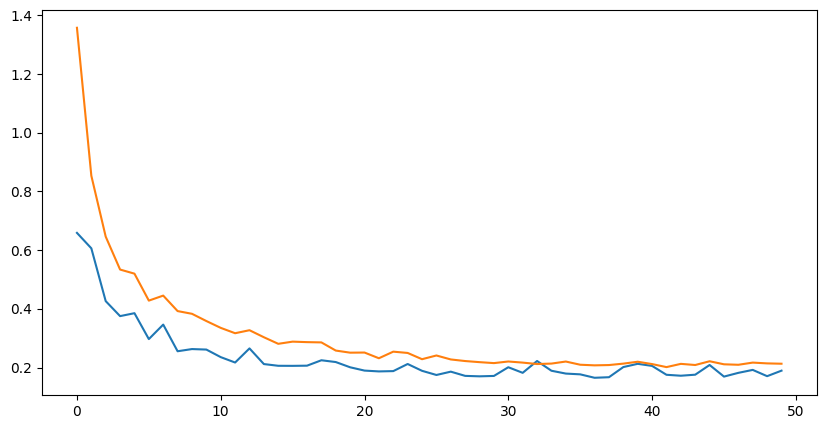

In [16]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)

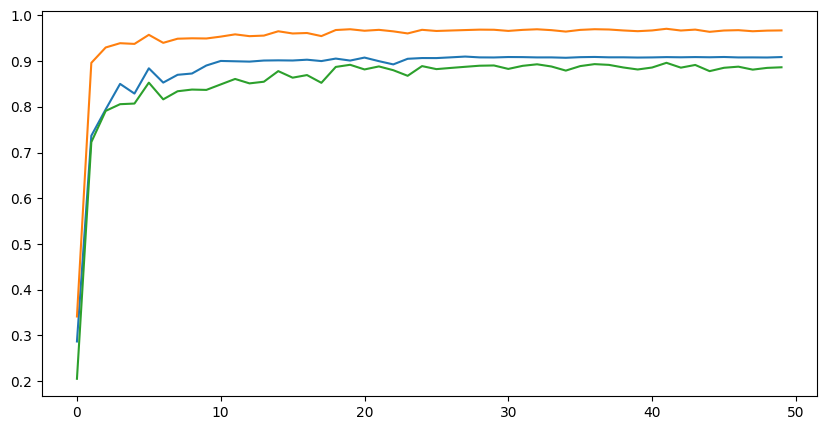

In [17]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)
plt.plot(val_accs)
plt.plot(val_mious)